In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from datetime import date
import sqlite3
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from arch import arch_model
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from pylab import rcParams 
import warnings
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 16,8
database = sqlite3.connect("Dataset.db")
data = pd.read_sql_query("SELECT * FROM Data", database)
data = data.rename(columns={"('EURUSD Curncy', 'PX_LAST')": "EURUSD","('EURCHF Curncy', 'PX_LAST')": "EURCHF","('EURDKK Curncy', 'PX_LAST')":"EURDKK","('EURGBP Curncy', 'PX_LAST')": "EURGBP","('EURCAD Curncy', 'PX_LAST')": "EURCAD","('EURAUD Curncy', 'PX_LAST')": "EURAUD","('EURJPY Curncy', 'PX_LAST')": "EURJPY","('EURNOK Curncy', 'PX_LAST')": "EURNOK","('EURSEK Curncy', 'PX_LAST')": "EURSEK"})
data['date'] = pd.to_datetime(data['date'], format = '%Y-%m-%d')
indexed_df = data.set_index('date')
ts_eurusd = indexed_df['EURUSD']
ts_eurusd = ts_eurusd['2019-01-02':'2022-04-14']
returns_series = np.log(ts_eurusd).diff().dropna()

In [2]:
euribor = pd.read_excel("Euribor.xlsx")
euribor = euribor.iloc[:,[0,1]]
euribor['Date'] = pd.to_datetime(euribor['Date'])
indexed_df = euribor.set_index('Date')
ts_euribor = indexed_df["Euribor"]
euribor_2 = pd.read_excel("Euribor_1.xlsx")
euribor_2['Date'] = pd.to_datetime(euribor_2['Unnamed: 0'])
indexed_df = euribor_2.set_index('Date')
ts_euribor_2 = indexed_df["Euribor"]
ts_euribor_2
ts_euribor = pd.concat([ts_euribor, ts_euribor_2]).sort_index()
ts_euribor = ts_euribor.dropna()
ts_euribor = ts_euribor/100
libor = pd.read_csv("LIBORUSD3M_NEW_1.CSV")
libor['Close'] = libor['Close'].str.rstrip("%").astype(float)/100
libor['Date'] = pd.to_datetime(libor['Date'])
indexed_df = libor.set_index('Date')
ts_libor = indexed_df['Close']
libor_2 = pd.read_csv("LIBORUSD3M_NEW_2.CSV")
libor_2['Close'] = libor_2['Close'].str.rstrip("%").astype(float)/100
libor_2['Date'] = pd.to_datetime(libor_2['Date'])
indexed_df = libor_2.set_index('Date')
ts_libor_2 = indexed_df['Close']
libor_3 = pd.read_csv("LIBORUSD3M_NEW_3.CSV")
libor_3['Close'] = libor_3['Close'].str.rstrip("%").astype(float)/100
libor_3['Date'] = pd.to_datetime(libor_3['Date'])
indexed_df = libor_3.set_index('Date')
ts_libor_3 = indexed_df['Close']
libor_4 = pd.read_csv("LIBORUSD3M_NEW_4.CSV")
libor_4['Close'] = libor_4['Close'].str.rstrip("%").astype(float)/100
libor_4['Date'] = pd.to_datetime(libor_4['Date'])
indexed_df = libor_4.set_index('Date')
ts_libor_4 = indexed_df['Close']
s3= pd.concat([ts_libor, ts_libor_2]).sort_index()
s4 = pd.concat([s3, ts_libor_3]).sort_index()
ts_libor = pd.concat([s4, ts_libor_4]).sort_index()
ts_libor = ts_libor.dropna()
fwd_rates = ts_libor.to_frame().join(ts_euribor.to_frame())
fwd_rates = fwd_rates.dropna()
fwd_rates.rename(columns={'Close': 'Libor $'}, inplace=True)
impl_vol = pd.read_csv("VolatilityScanner_DataDeck_AtTheMoneyVols_EURUSD.CSV")
impl_vol['date'] = pd.to_datetime(impl_vol['date'])
indexed_df = impl_vol.set_index('date')
impl_vol['EURUSDV1M Curncy'] = impl_vol['EURUSDV1M Curncy']/100
ts_impl_vol = indexed_df['EURUSDV3M Curncy']
ts_impl_vol = ts_impl_vol/100
ts_impl_vol = ts_impl_vol.dropna()
fwd_rates = fwd_rates.join(ts_impl_vol.to_frame())
fwd_rates.rename(columns={'EURUSDV3M Curncy': 'Implied_Vol3M'}, inplace=True)
fwd_rates

,Libor $,Euribor,Implied_Vol3M
Date,,,
2019-01-02,0.027939,-0.00310,0.063025
2019-01-03,0.027950,-0.00309,0.058500
2019-01-04,0.028039,-0.00309,0.055925
2019-01-07,0.027968,-0.00310,0.052500
2019-01-08,0.027825,-0.00308,0.059125
...,...,...,...
2022-04-08,0.010107,-0.00449,0.100650
2022-04-11,0.010214,-0.00435,0.108775
2022-04-12,0.010384,-0.00433,NaN


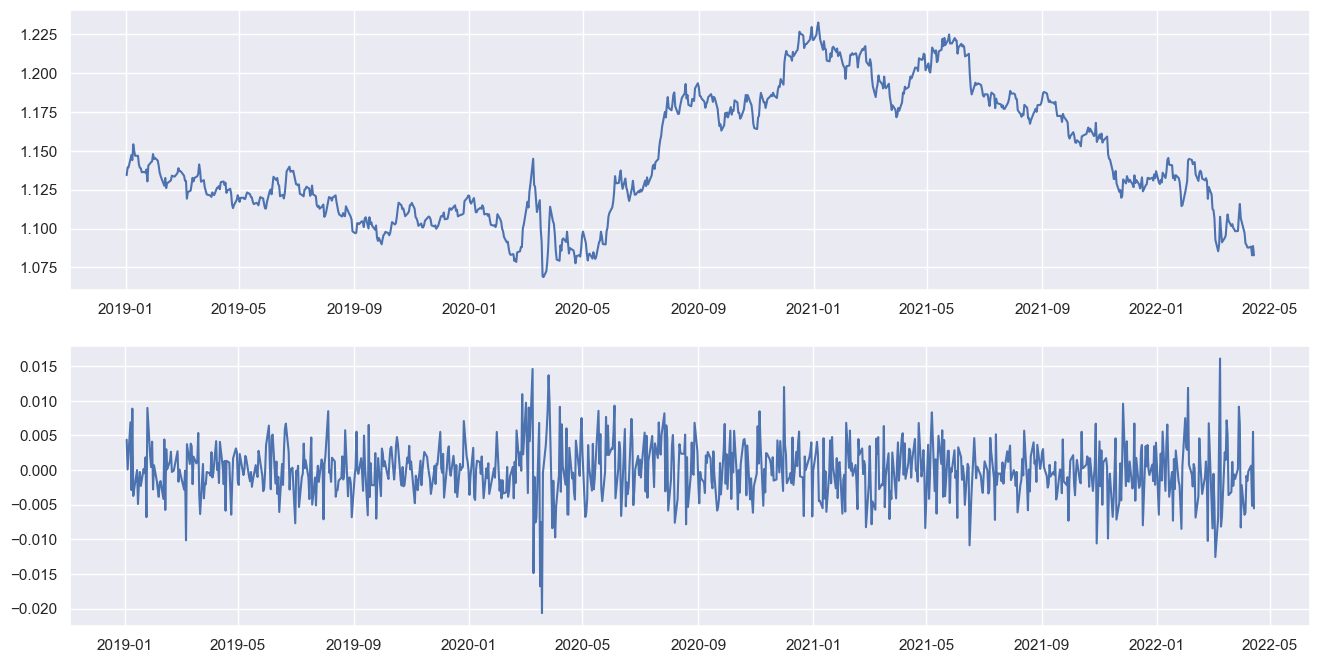

In [3]:
fig, (ax1, ax2) = plt.subplots(2)

ax1.plot(ts_eurusd.index.to_pydatetime(), ts_eurusd.values)
ax2.plot(returns_series)

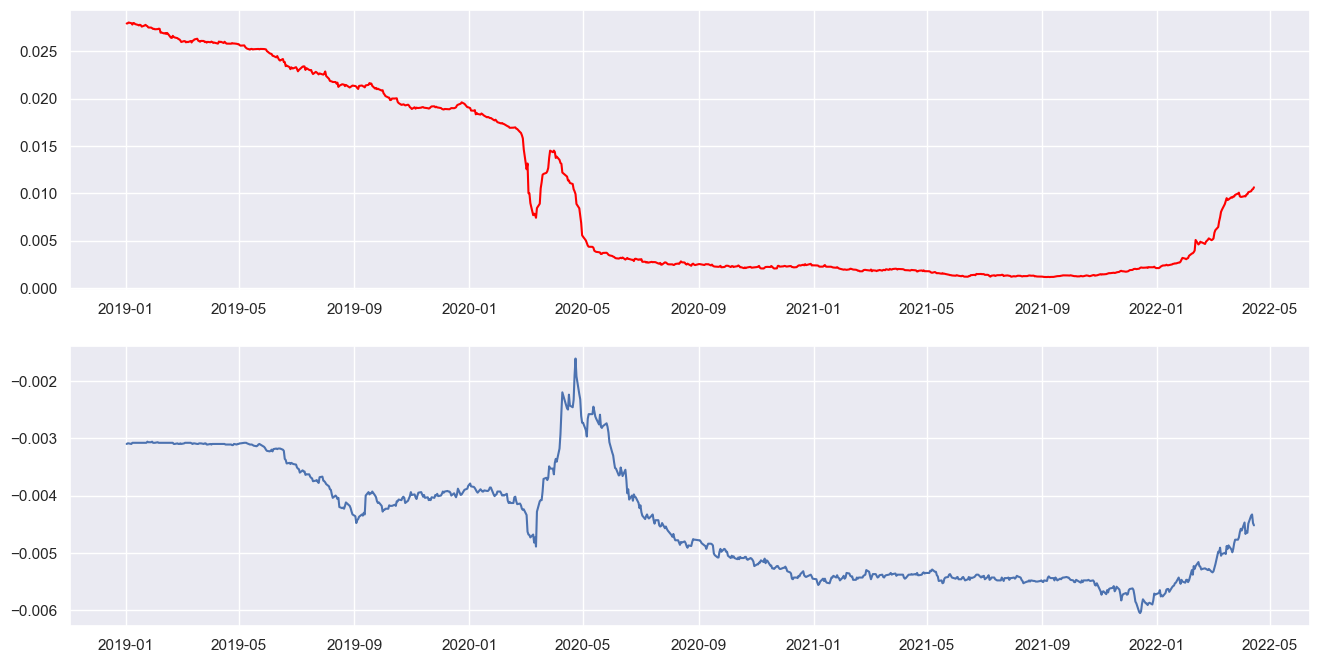

In [4]:
fig, (ax1, ax2) = plt.subplots(2)

ax1.plot(fwd_rates['Libor $'].index.to_pydatetime(), fwd_rates['Libor $'].values, color = 'red')
ax2.plot(fwd_rates['Euribor'].index.to_pydatetime(), fwd_rates['Euribor'].values)

In [5]:
ann_volatility_25 = (returns_series.rolling(window = 25).std()*np.sqrt(252)).dropna()

In [6]:
vols = ann_volatility_25.to_frame().join(ts_impl_vol.to_frame())
vols = vols.dropna()
vols.rename(columns={'EURUSD': 'Historical'}, inplace=True)
vols.rename(columns={'EURUSDV3M Curncy': 'Implied'}, inplace=True)

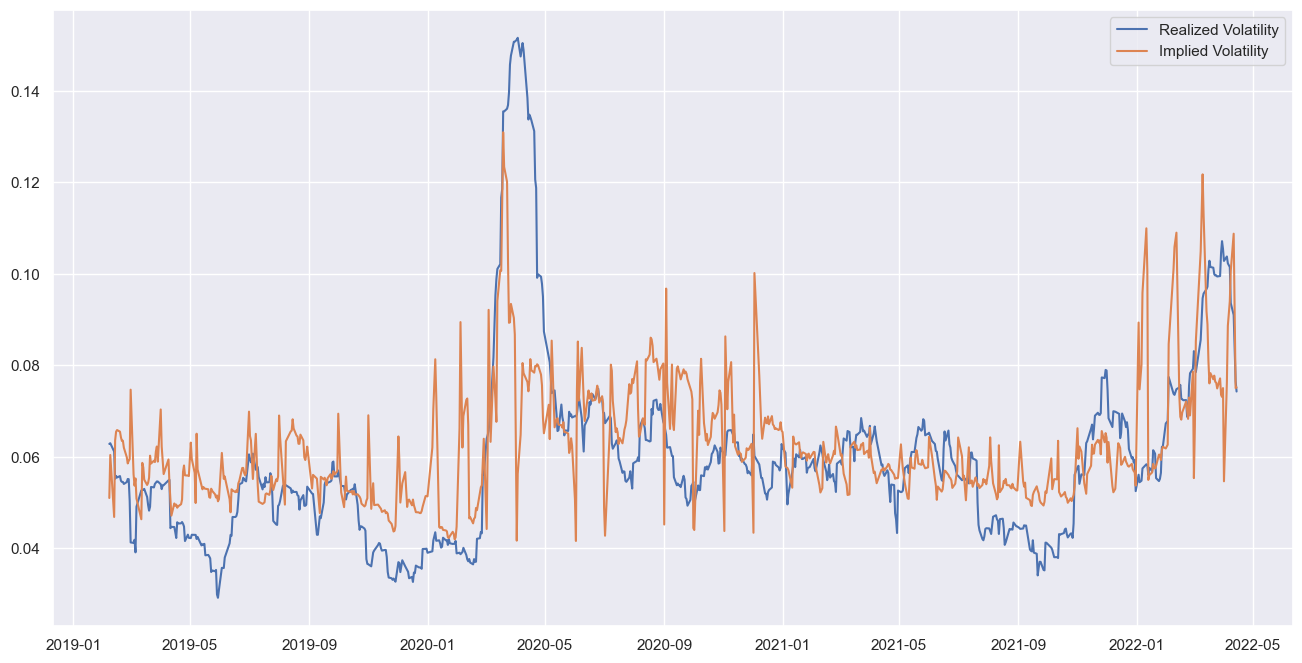

In [7]:
plt.plot(vols.dropna())
plt.legend(['Realized Volatility','Implied Volatility'])

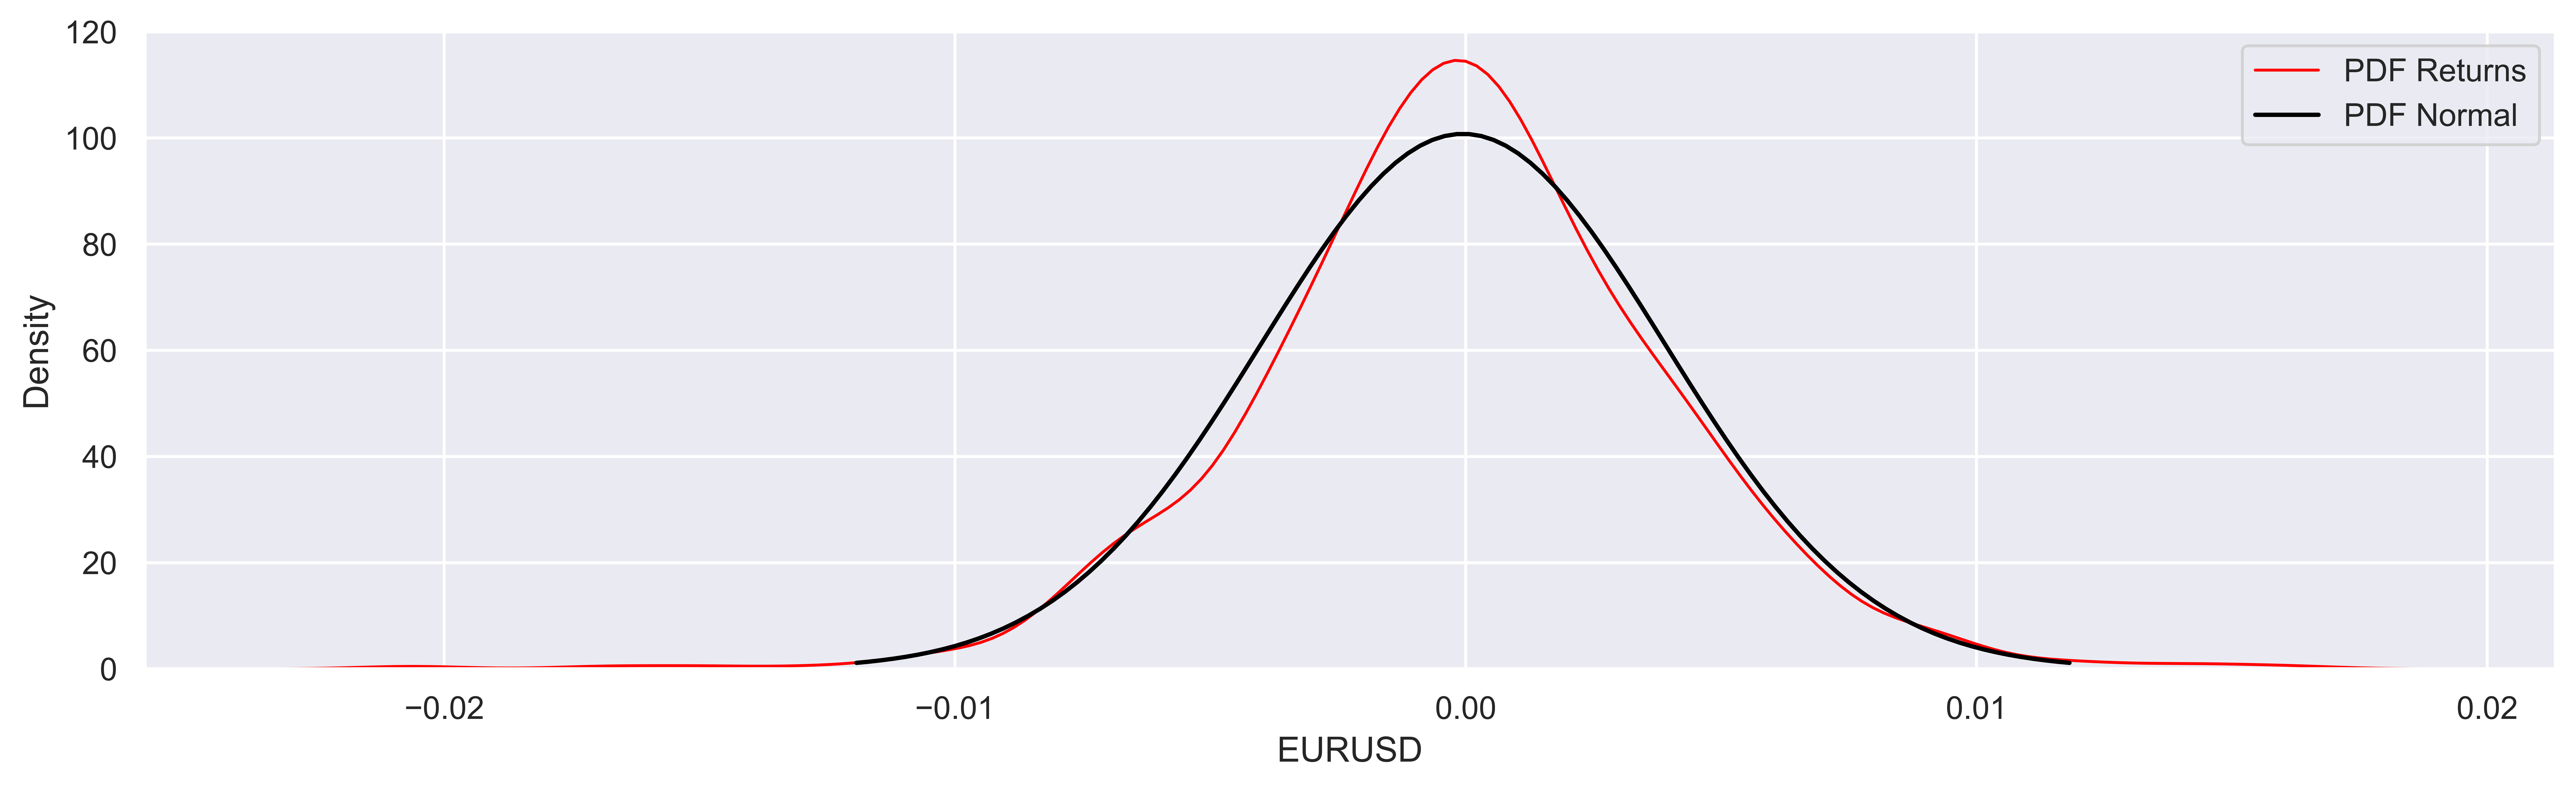

In [13]:
plt.figure(dpi = 1000, figsize=(15, 4))
sns.distplot(returns_series, hist=False, kde=True, bins=int(180/5), color = 'red',kde_kws={'linewidth': 1})
x = np.linspace(np.mean(returns_series) - 3*np.std(returns_series), np.mean(returns_series) +
3*np.std(returns_series), 100)
plt.plot(x, norm.pdf(x, np.mean(returns_series), np.std(returns_series)), color = 'black')
plt.legend(['PDF Returns', 'PDF Normal'])

In [24]:
def check_stationarity(timeseries):
    
    #Determing rolling statistics
    rolling_mean = timeseries.rolling(window=25,center=False).mean() 
    rolling_std = timeseries.rolling(window=25,center=False).std()

    #Plot rolling statistics:
    original = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dickey_fuller_test = adfuller(timeseries, autolag='AIC')
    dfresults = pd.Series(dickey_fuller_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dickey_fuller_test[4].items():
        dfresults['Critical Value (%s)'%key] = value
    print (dfresults)

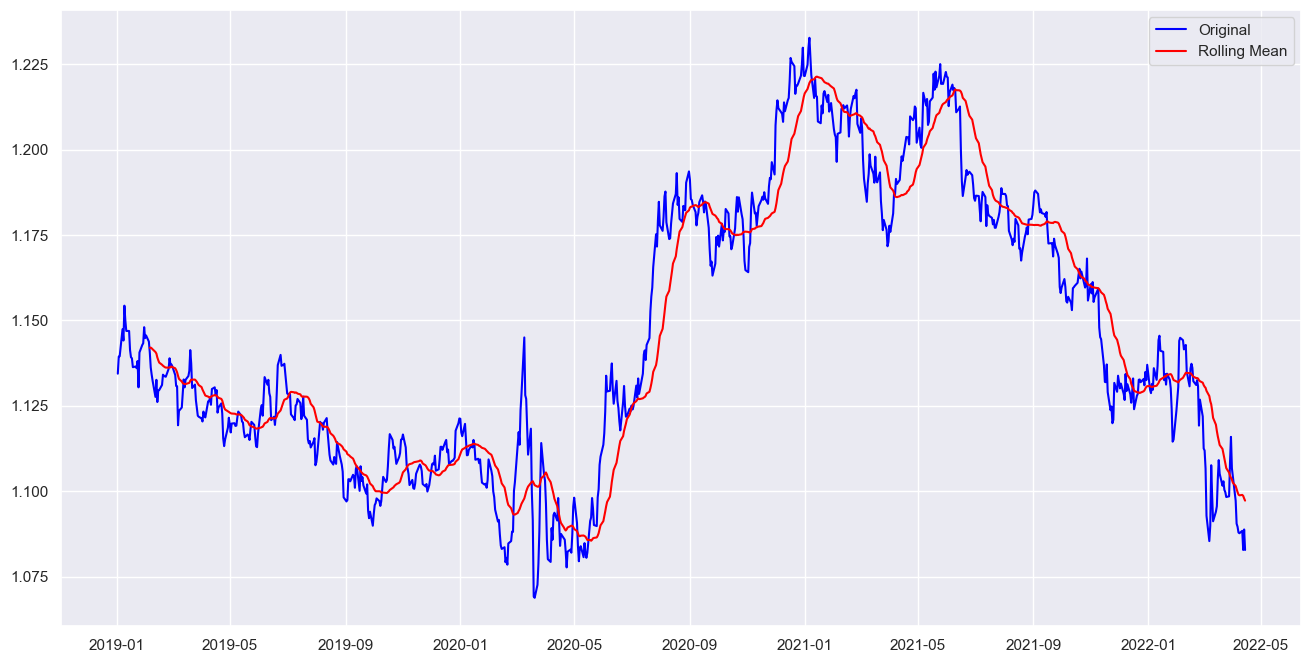

Results of Dickey-Fuller Test:
Test Statistic                  -1.113236
p-value                          0.709765
#Lags Used                       6.000000
Number of Observations Used    850.000000
Critical Value (1%)             -3.438067
Critical Value (5%)             -2.864946
Critical Value (10%)            -2.568584
dtype: float64


In [8]:
check_stationarity(ts_eurusd)

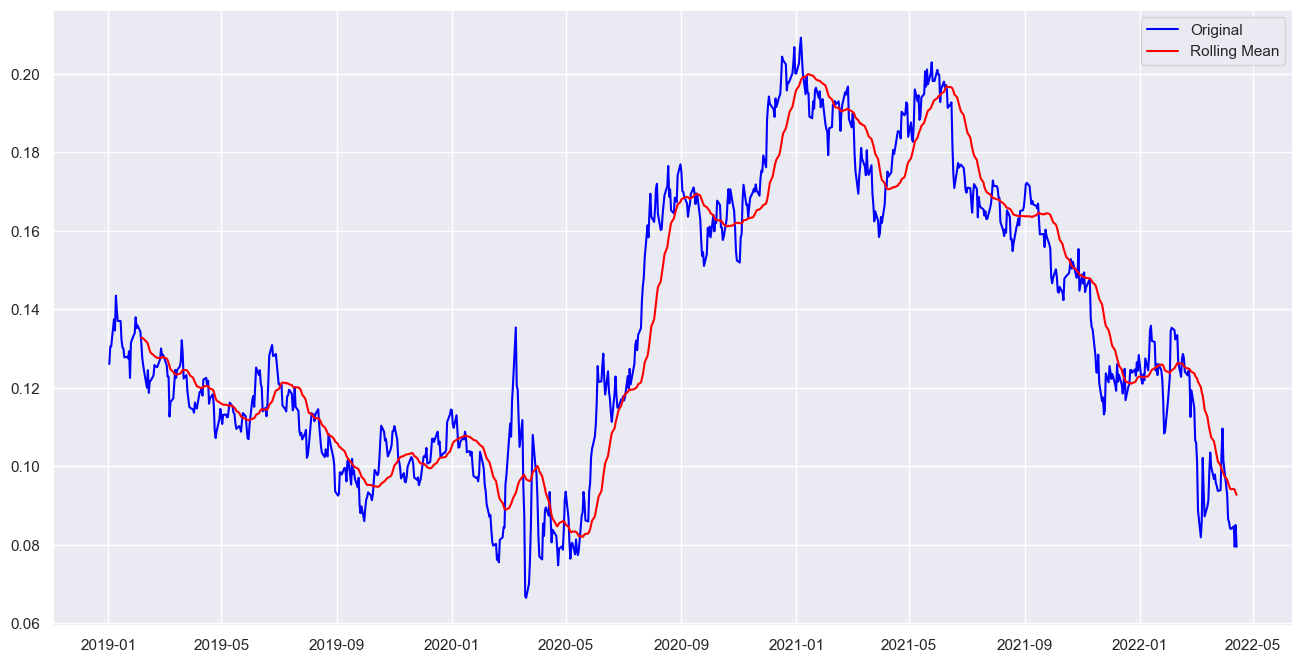

Results of Dickey-Fuller Test:
Test Statistic                  -1.118776
p-value                          0.707526
#Lags Used                       6.000000
Number of Observations Used    850.000000
Critical Value (1%)             -3.438067
Critical Value (5%)             -2.864946
Critical Value (10%)            -2.568584
dtype: float64


In [9]:
check_stationarity(np.log(ts_eurusd))

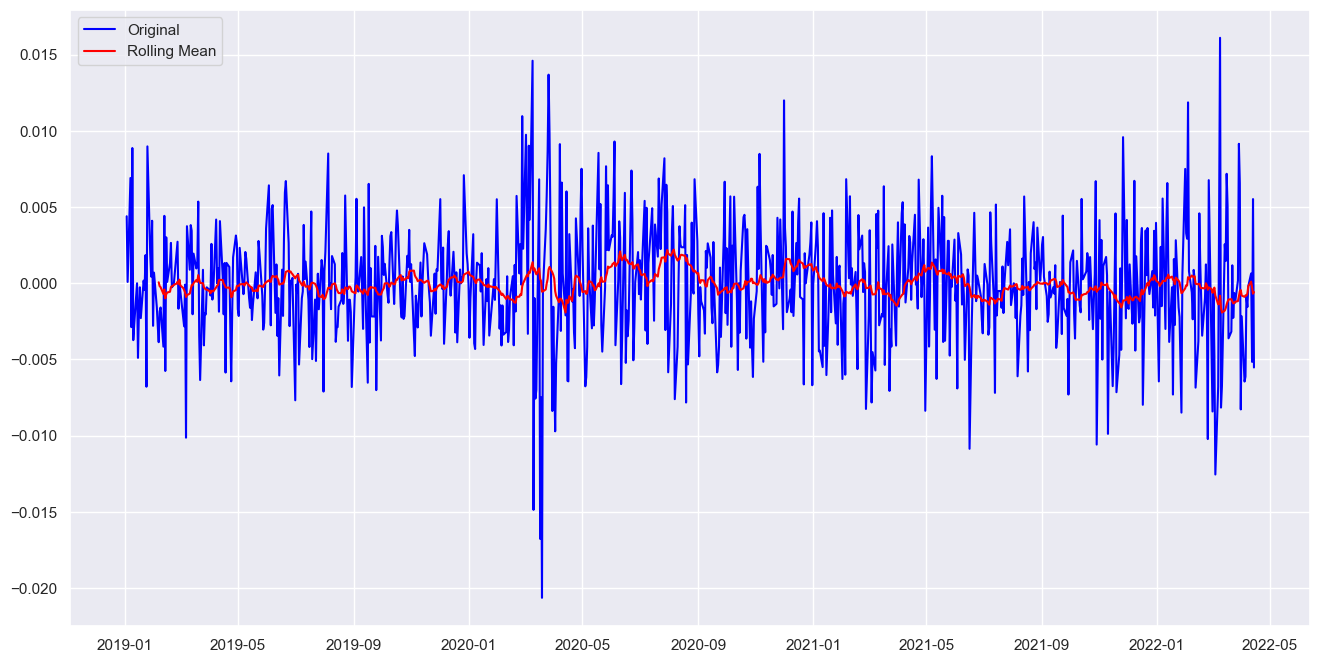

Results of Dickey-Fuller Test:
Test Statistic                -1.333868e+01
p-value                        5.980527e-25
#Lags Used                     5.000000e+00
Number of Observations Used    8.500000e+02
Critical Value (1%)           -3.438067e+00
Critical Value (5%)           -2.864946e+00
Critical Value (10%)          -2.568584e+00
dtype: float64


In [12]:
check_stationarity(returns_series)

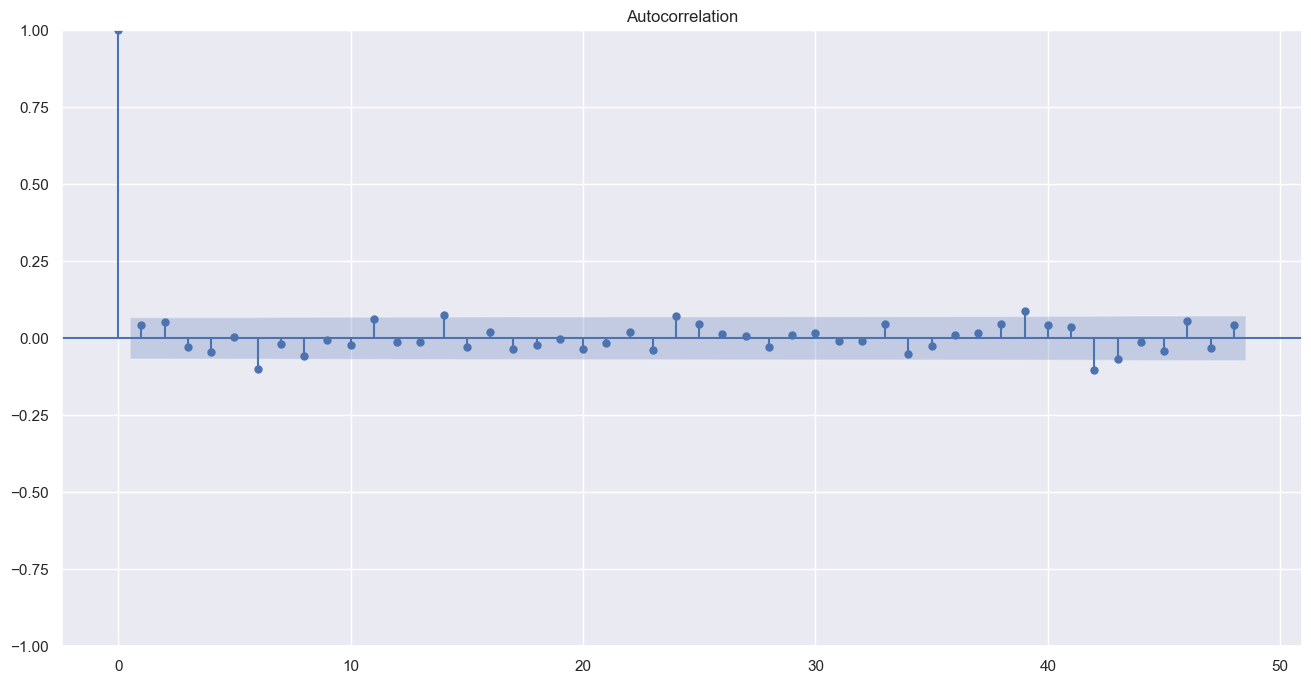

In [13]:
ax = sm.tsa.graphics.plot_acf(returns_series, lags=48)

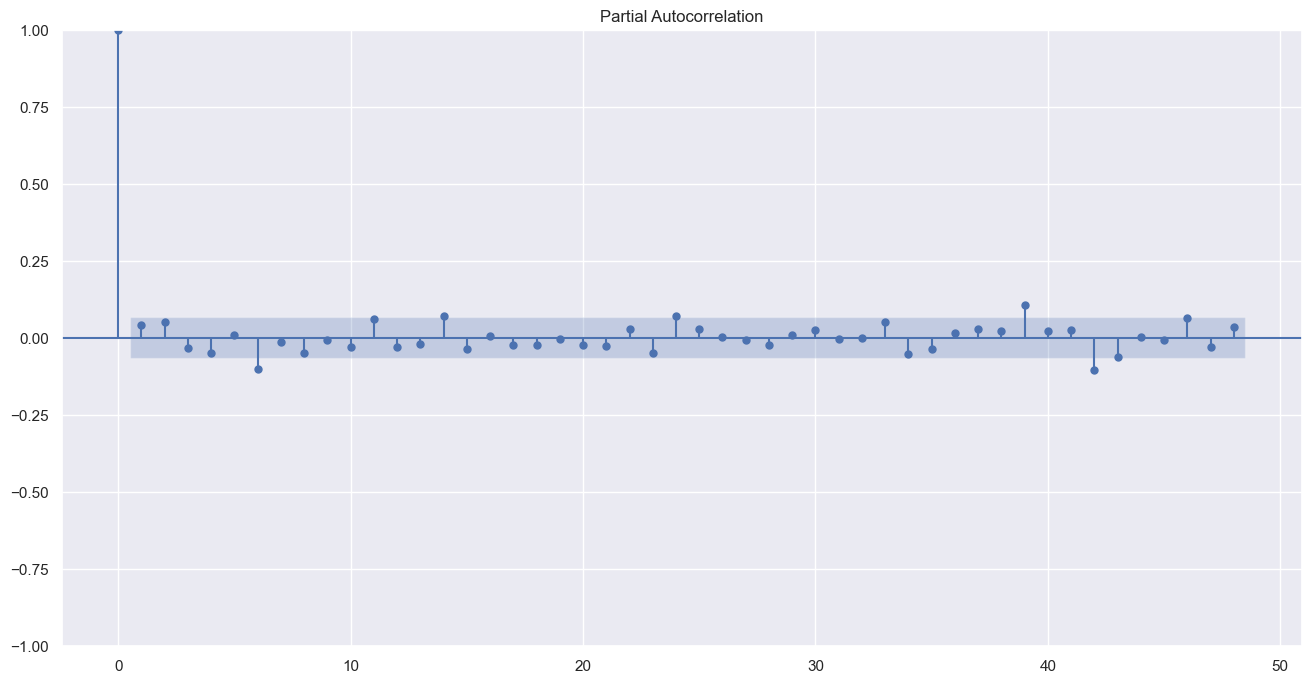

In [14]:
ax = sm.tsa.graphics.plot_pacf(returns_series, lags=48)

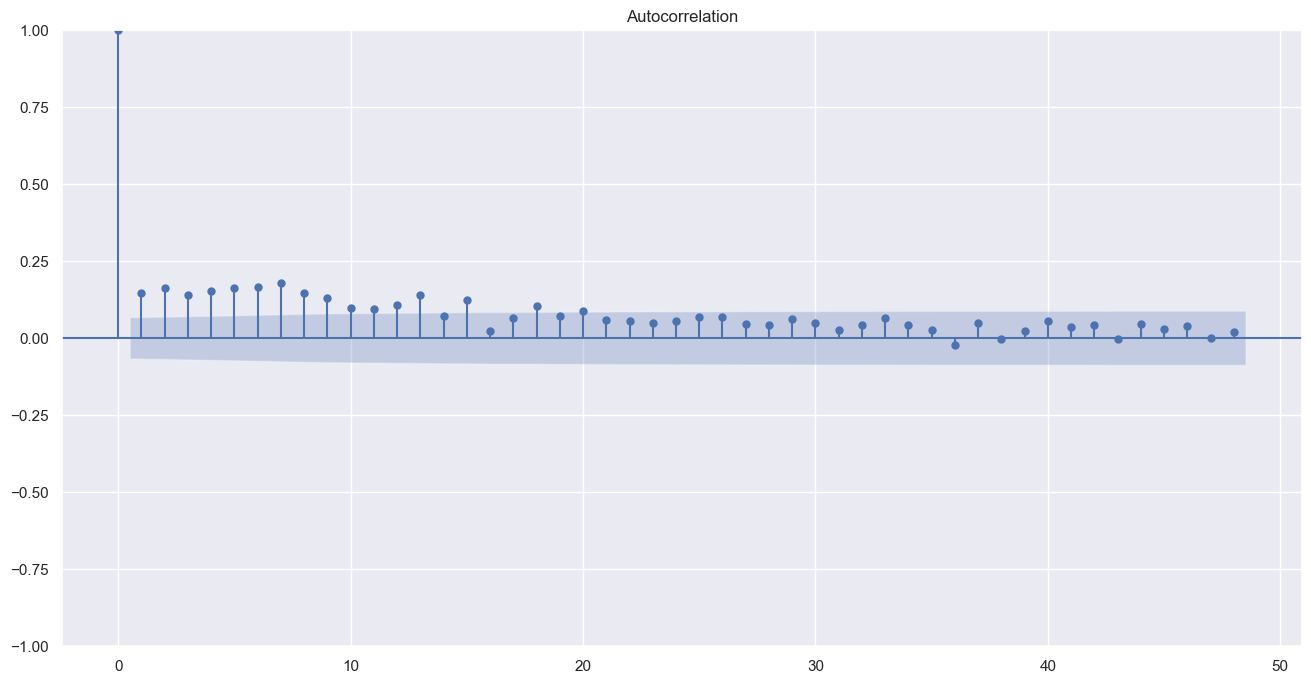

In [15]:
ax = sm.tsa.graphics.plot_acf(abs(returns_series), lags=48)

In [16]:
sm.stats.acorr_ljungbox(returns_series,lags = 30,return_df = True)

,lb_stat,lb_pvalue
1,1.553364,0.212640
2,3.876468,0.143958
3,4.577630,0.205469
4,6.533253,0.162707
5,6.542750,0.256927
6,15.613642,0.015985
7,15.918255,0.025874
8,18.930347,0.015237
9,18.978588,0.025376
10,19.432224,0.035104


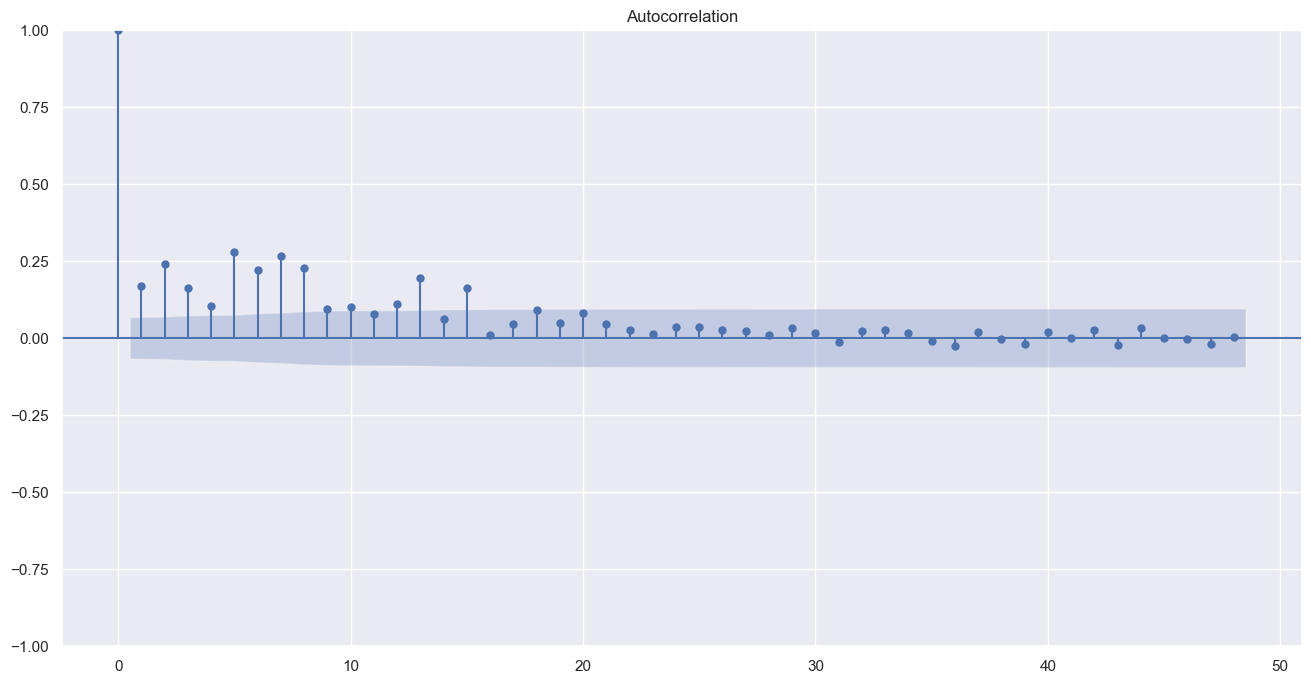

In [17]:
ax = sm.tsa.graphics.plot_acf(returns_series**2, lags=48)

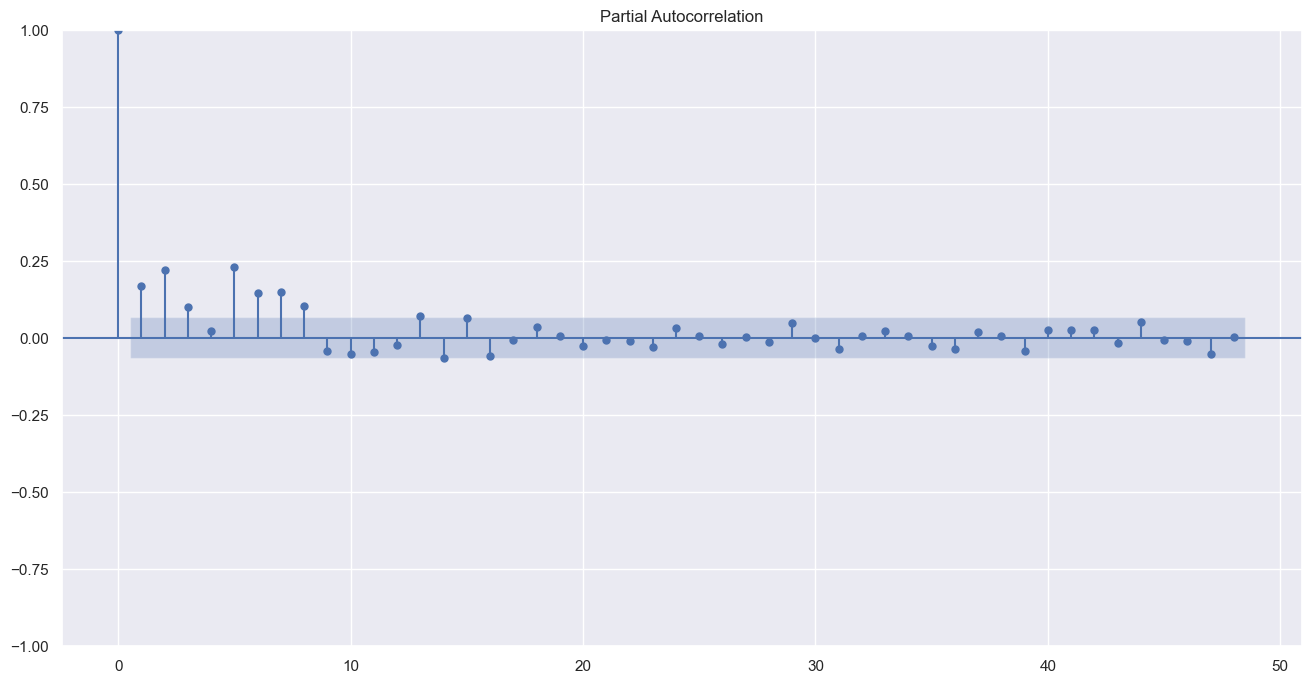

In [18]:
ax = sm.tsa.graphics.plot_pacf(returns_series**2, lags=48)

In [19]:
sm.stats.acorr_ljungbox(returns_series**2,lags = 30,return_df = True)

,lb_stat,lb_pvalue
1,24.010156,9.582890e-07
2,73.670249,1.006256e-16
3,95.775071,1.258170e-20
4,105.141217,7.903172e-22
5,172.349520,2.300109e-35
6,213.797523,2.185234e-43
7,275.313179,1.121555e-55
8,320.043405,2.218248e-64
9,327.804495,3.257446e-65
10,336.760762,2.562492e-66


In [20]:
euribor = pd.read_excel("Euribor.xlsx")
euribor = euribor.iloc[:,[0,1]]
euribor['Date'] = pd.to_datetime(euribor['Date'])
indexed_df = euribor.set_index('Date')
ts_euribor = indexed_df["Euribor"]
euribor_2 = pd.read_excel("Euribor_1.xlsx")
euribor_2['Date'] = pd.to_datetime(euribor_2['Unnamed: 0'])
indexed_df = euribor_2.set_index('Date')
ts_euribor_2 = indexed_df["Euribor"]
ts_euribor_2
ts_euribor = pd.concat([ts_euribor, ts_euribor_2]).sort_index()
ts_euribor = ts_euribor.dropna()
ts_euribor = ts_euribor/100

In [21]:
libor = pd.read_csv("LIBORUSD3M_NEW_1.CSV")
libor['Close'] = libor['Close'].str.rstrip("%").astype(float)/100
libor['Date'] = pd.to_datetime(libor['Date'])
indexed_df = libor.set_index('Date')
ts_libor = indexed_df['Close']
libor_2 = pd.read_csv("LIBORUSD3M_NEW_2.CSV")
libor_2['Close'] = libor_2['Close'].str.rstrip("%").astype(float)/100
libor_2['Date'] = pd.to_datetime(libor_2['Date'])
indexed_df = libor_2.set_index('Date')
ts_libor_2 = indexed_df['Close']
libor_3 = pd.read_csv("LIBORUSD3M_NEW_3.CSV")
libor_3['Close'] = libor_3['Close'].str.rstrip("%").astype(float)/100
libor_3['Date'] = pd.to_datetime(libor_3['Date'])
indexed_df = libor_3.set_index('Date')
ts_libor_3 = indexed_df['Close']
libor_4 = pd.read_csv("LIBORUSD3M_NEW_4.CSV")
libor_4['Close'] = libor_4['Close'].str.rstrip("%").astype(float)/100
libor_4['Date'] = pd.to_datetime(libor_4['Date'])
indexed_df = libor_4.set_index('Date')
ts_libor_4 = indexed_df['Close']
s3= pd.concat([ts_libor, ts_libor_2]).sort_index()
s4 = pd.concat([s3, ts_libor_3]).sort_index()
ts_libor = pd.concat([s4, ts_libor_4]).sort_index()
ts_libor = ts_libor.dropna()
ts_libor

Date
2019-01-02    0.027939
2019-01-03    0.027950
2019-01-04    0.028039
2019-01-06    0.028039
2019-01-07    0.027968
                ...   
2022-04-11    0.010214
2022-04-12    0.010384
2022-04-13    0.010443
2022-04-14    0.010627
2022-04-15    0.010627
Name: Close, Length: 853, dtype: float64

In [22]:
fwd_rates = ts_libor.to_frame().join(ts_euribor.to_frame())
fwd_rates = fwd_rates.dropna()
fwd_rates.rename(columns={'Close': 'Libor $'}, inplace=True)
fwd_rates

,Libor $,Euribor
Date,,
2019-01-02,0.027939,-0.00310
2019-01-03,0.027950,-0.00309
2019-01-04,0.028039,-0.00309
2019-01-07,0.027968,-0.00310
2019-01-08,0.027825,-0.00308
...,...,...
2022-04-08,0.010107,-0.00449
2022-04-11,0.010214,-0.00435
2022-04-12,0.010384,-0.00433


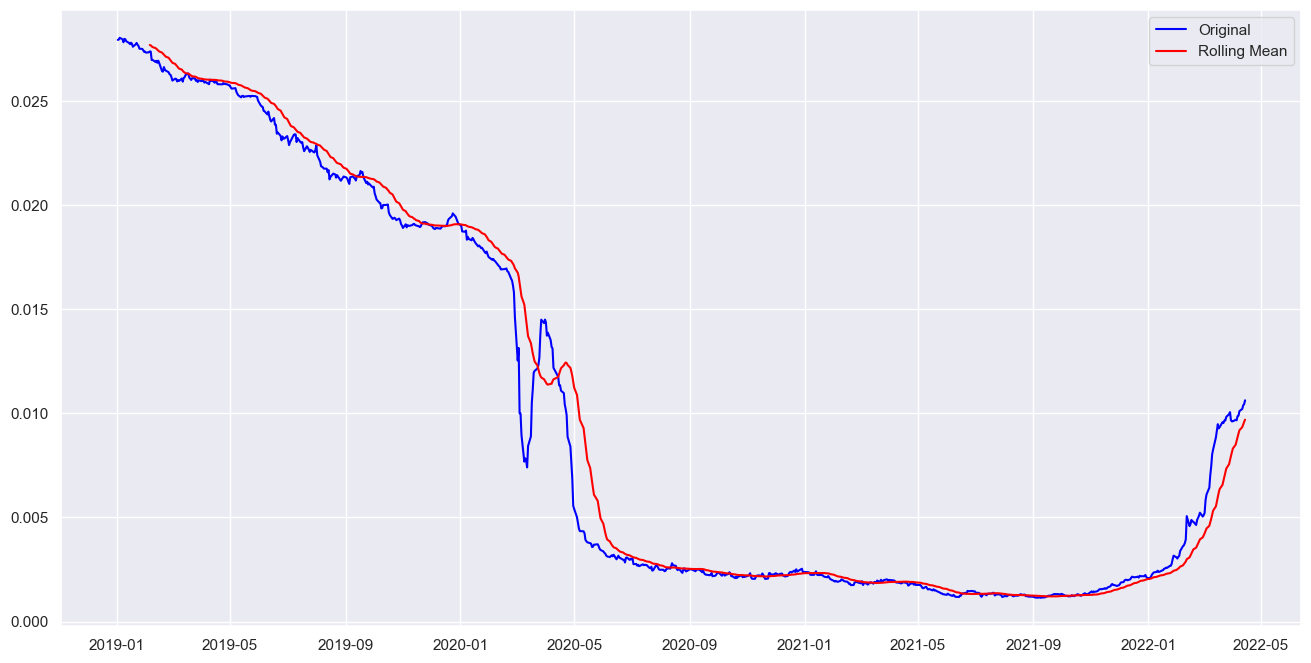

Results of Dickey-Fuller Test:
Test Statistic                  -1.980710
p-value                          0.295095
#Lags Used                      21.000000
Number of Observations Used    813.000000
Critical Value (1%)             -3.438419
Critical Value (5%)             -2.865102
Critical Value (10%)            -2.568667
dtype: float64


In [25]:
check_stationarity(fwd_rates['Libor $'])

In [26]:
ret_libor = np.log(fwd_rates['Libor $']).diff().dropna()
ret_libor


Date
2019-01-03    0.000401
2019-01-04    0.003172
2019-01-07   -0.002525
2019-01-08   -0.005130
2019-01-09    0.005870
                ...   
2022-04-08    0.021856
2022-04-11    0.010551
2022-04-12    0.016506
2022-04-13    0.005627
2022-04-14    0.017485
Name: Libor $, Length: 834, dtype: float64

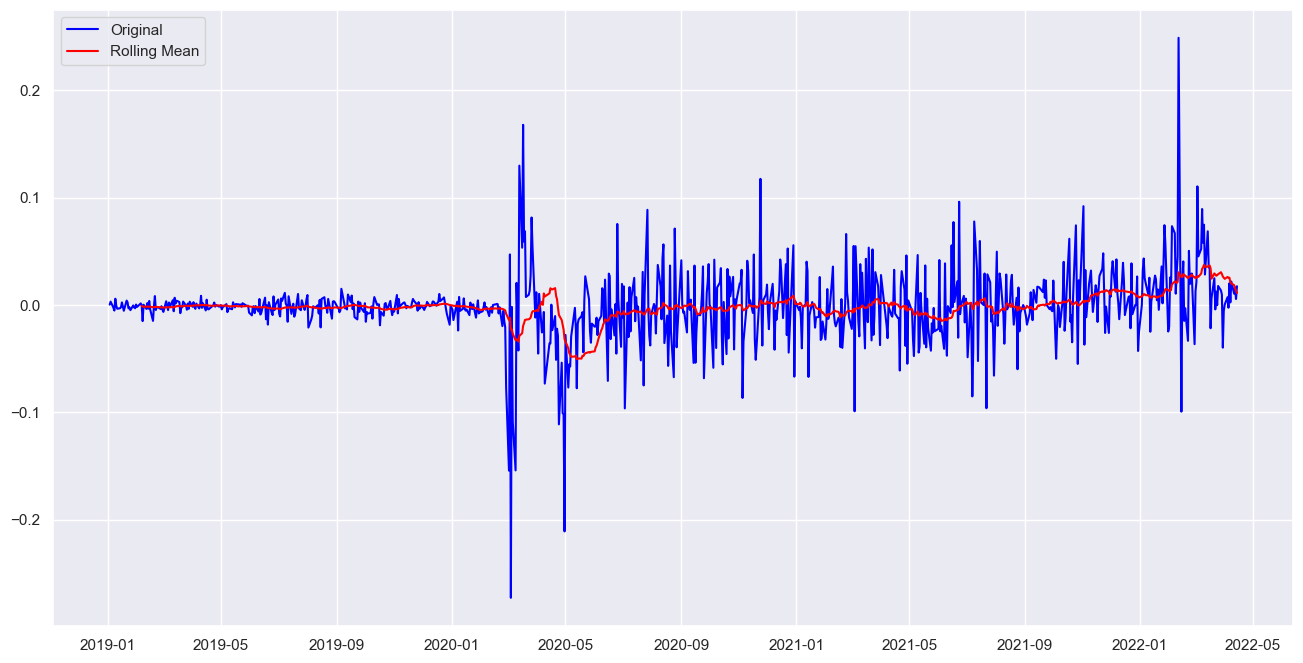

Results of Dickey-Fuller Test:
Test Statistic                -6.907853e+00
p-value                        1.233998e-09
#Lags Used                     1.000000e+01
Number of Observations Used    8.230000e+02
Critical Value (1%)           -3.438321e+00
Critical Value (5%)           -2.865058e+00
Critical Value (10%)          -2.568643e+00
dtype: float64


In [27]:
check_stationarity(ret_libor)

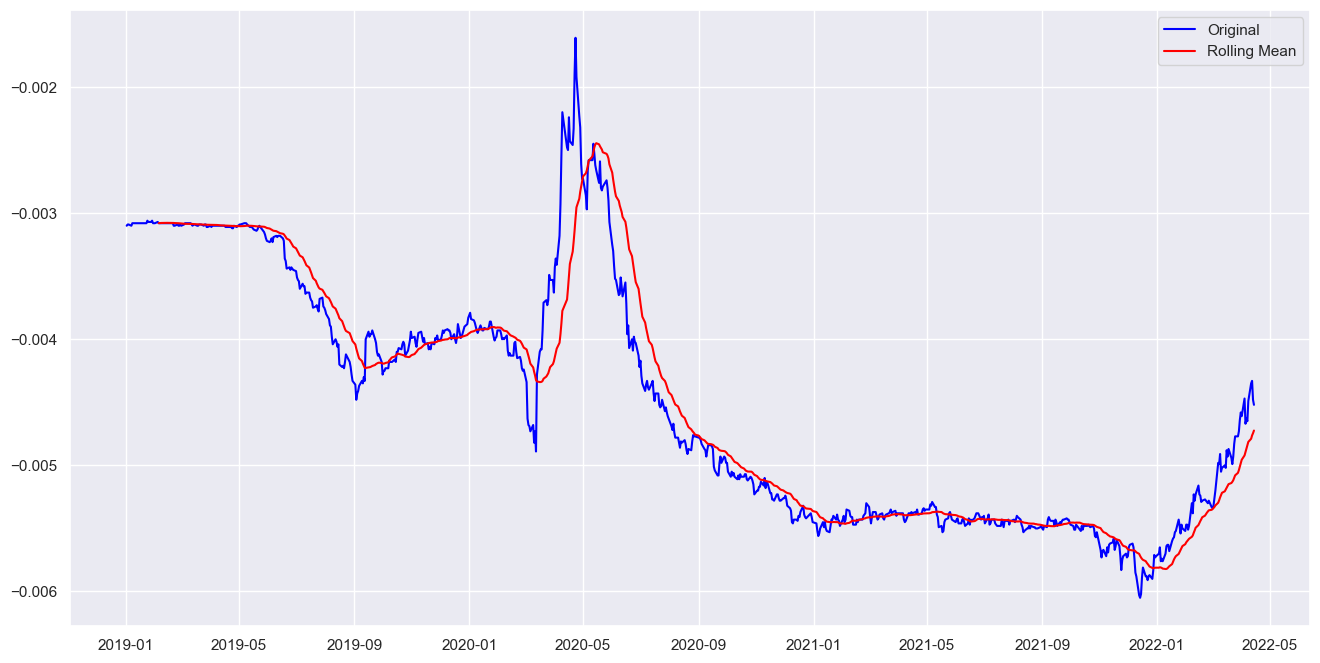

Results of Dickey-Fuller Test:
Test Statistic                  -2.068774
p-value                          0.257255
#Lags Used                      18.000000
Number of Observations Used    816.000000
Critical Value (1%)             -3.438389
Critical Value (5%)             -2.865088
Critical Value (10%)            -2.568660
dtype: float64


In [28]:
check_stationarity(fwd_rates['Euribor'])

In [29]:
ret_euribor = fwd_rates['Euribor'].diff().dropna()
ret_euribor

Date
2019-01-03    0.00001
2019-01-04    0.00000
2019-01-07   -0.00001
2019-01-08    0.00002
2019-01-09    0.00000
               ...   
2022-04-08    0.00016
2022-04-11    0.00014
2022-04-12    0.00002
2022-04-13   -0.00015
2022-04-14   -0.00004
Name: Euribor, Length: 834, dtype: float64

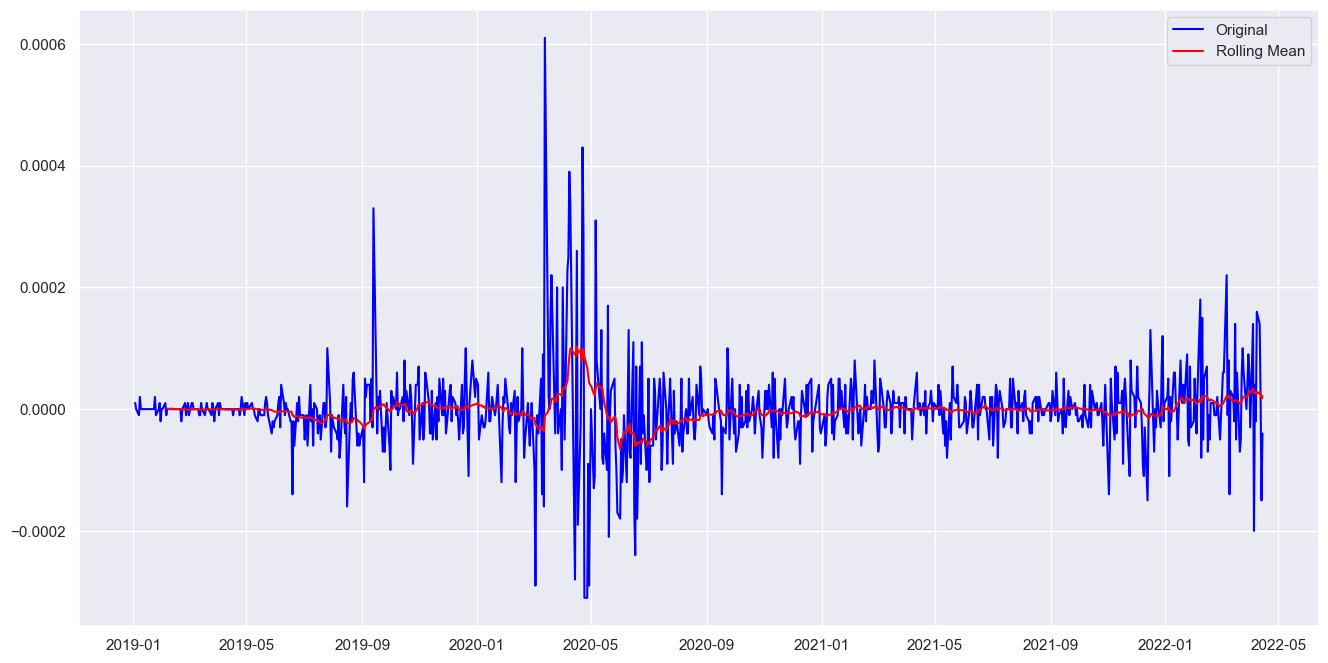

Results of Dickey-Fuller Test:
Test Statistic                  -4.928160
p-value                          0.000031
#Lags Used                      17.000000
Number of Observations Used    816.000000
Critical Value (1%)             -3.438389
Critical Value (5%)             -2.865088
Critical Value (10%)            -2.568660
dtype: float64


In [30]:
check_stationarity(ret_euribor)

In [31]:
fwd_rates_ret = ret_libor.to_frame().join(ret_euribor.to_frame())
fwd_rates_ret

,Libor $,Euribor
Date,,
2019-01-03,0.000401,0.00001
2019-01-04,0.003172,0.00000
2019-01-07,-0.002525,-0.00001
2019-01-08,-0.005130,0.00002
2019-01-09,0.005870,0.00000
...,...,...
2022-04-08,0.021856,0.00016
2022-04-11,0.010551,0.00014
2022-04-12,0.016506,0.00002


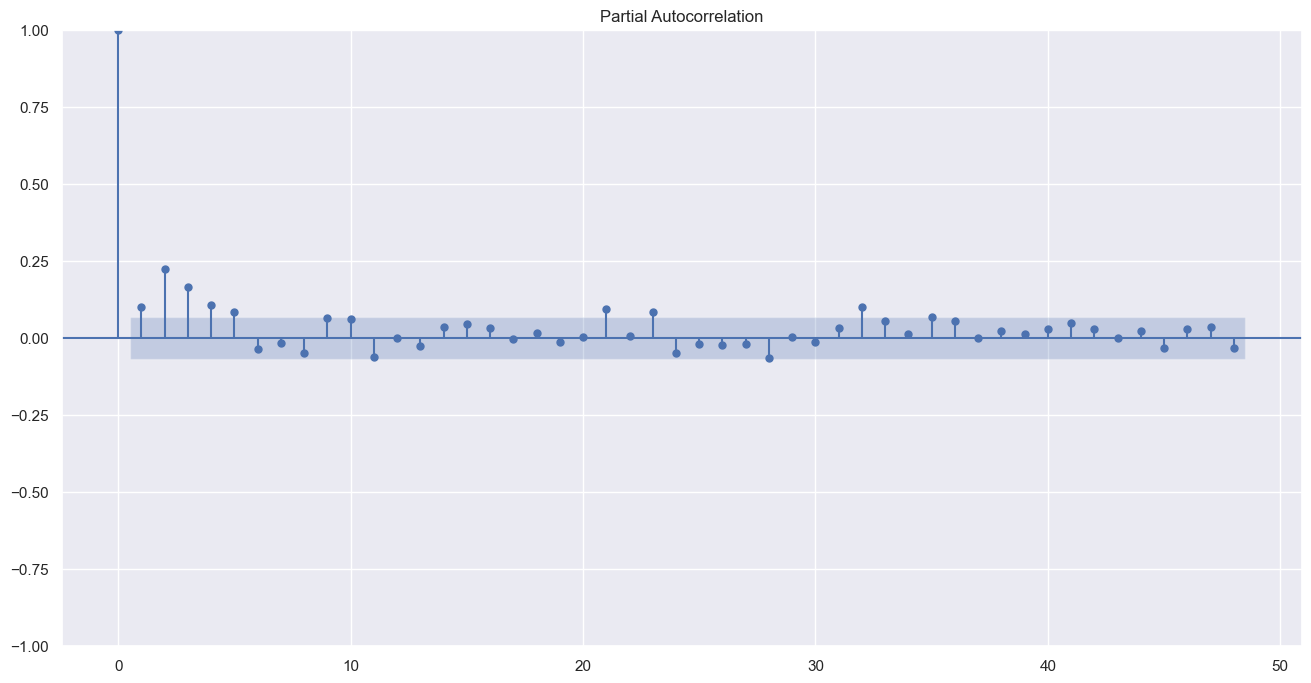

In [32]:
ax = plot_pacf(ret_libor,lags = 48)

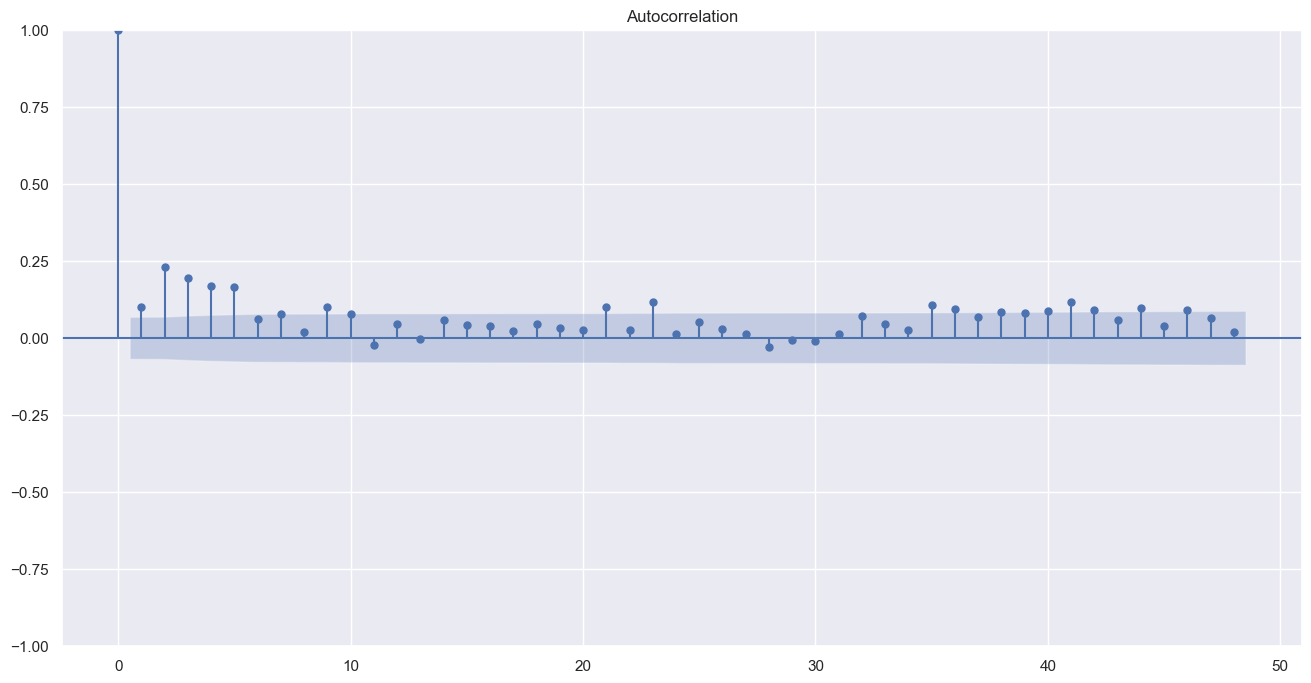

In [33]:
ax = sm.tsa.graphics.plot_acf(ret_libor,lags = 48)

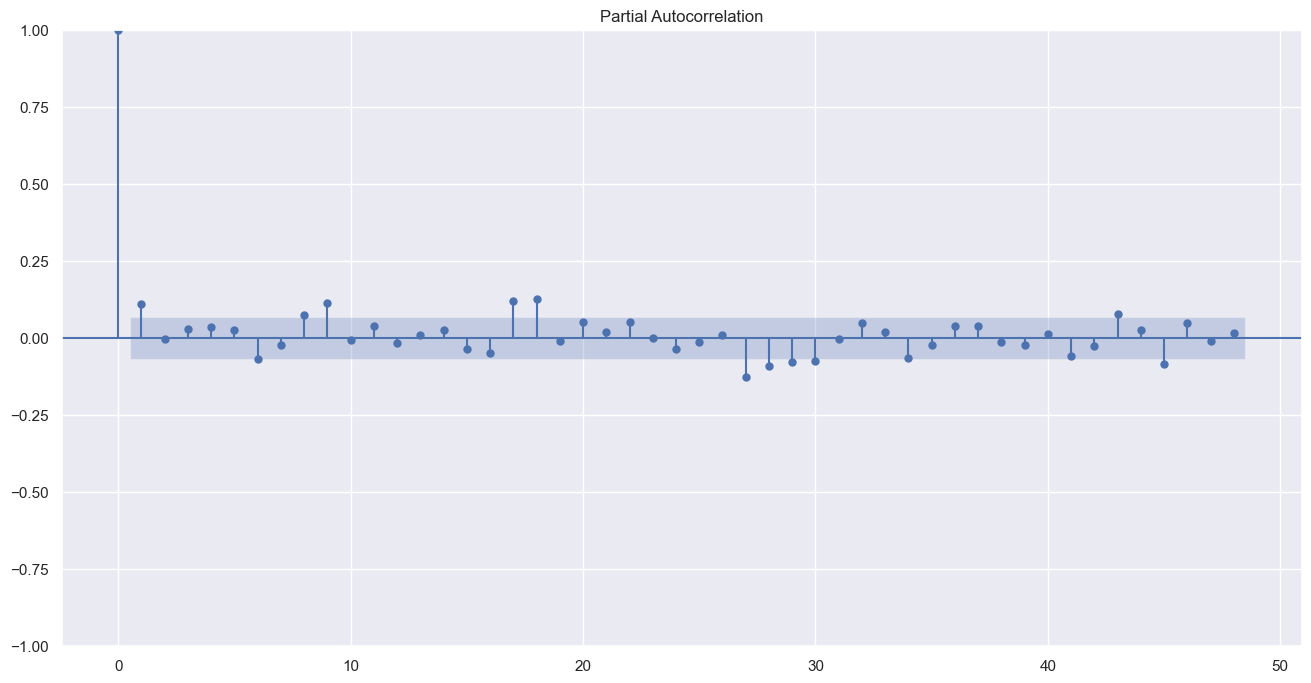

In [34]:
ax = plot_pacf(ret_euribor,lags = 48)

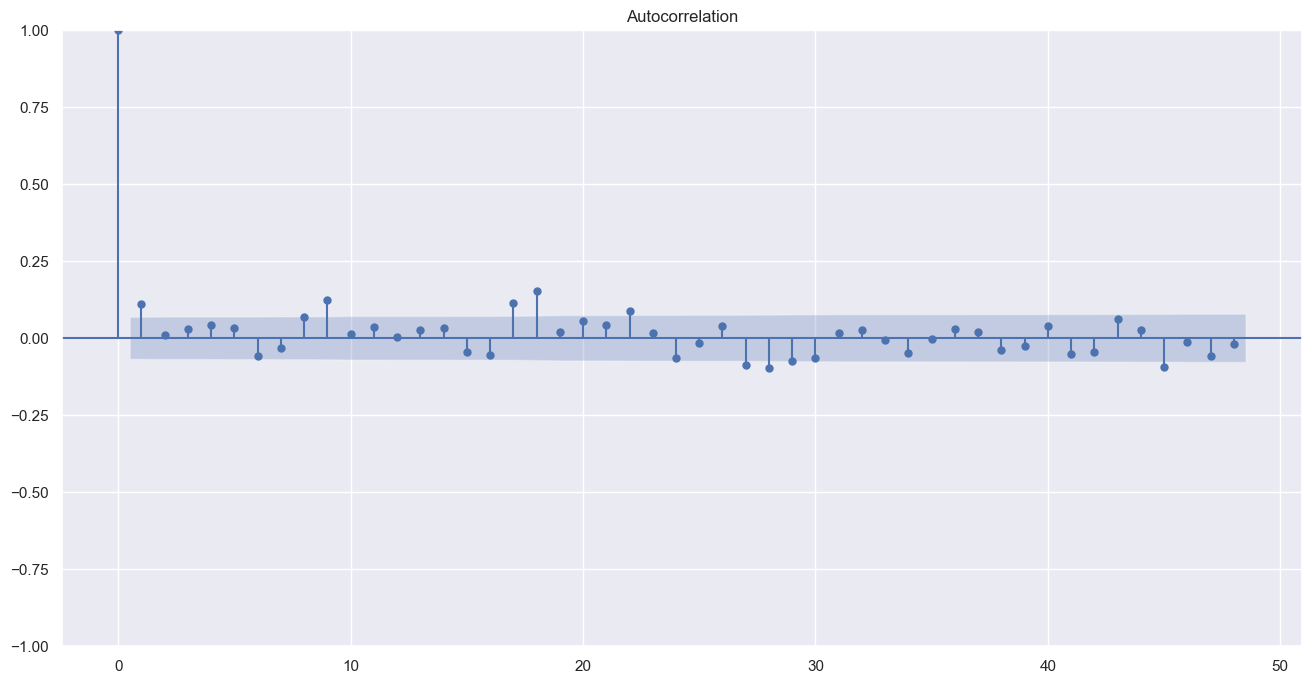

In [35]:
ax = sm.tsa.graphics.plot_acf(ret_euribor, lags=48)